In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,PowerTransformer,Normalizer


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import train_test_split


import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import joblib

## Preparing the Week-Wise Disease Dataset

In [2]:
# predictive_area = 'Aileu'

In [3]:
population_census = pd.read_excel('../datasets/population_data/all_population_census.xlsx')
# population_census.head()

In [4]:
def returnMunicipalitiesWiseWeeklyDisease():
    
    spatial_data = pd.read_csv('../datasets/Highest spatial resolution data_TIMOR-LESTE_19850101_20221231.csv')
    amd_code_list=list(spatial_data.FAO_GAUL_code.unique())
    name_code_dict={}
    code_name_dict={}
    for code in amd_code_list[1:]:
        admin_name = spatial_data['adm_1_name'].where(spatial_data.FAO_GAUL_code==code).dropna().unique()[0].capitalize()
        name_code_dict[admin_name]=code
        code_name_dict[code]=admin_name

    weekly_disease_gdf = gpd.read_file('week_wise_diarrhea_incedence_from_weekly_data.geojson')
    weekly_disease_df = weekly_disease_gdf.copy(deep=True)
    weekly_disease_df.rename(columns = {'index':'Municipalities'},inplace=True)
    weekly_disease_df.drop(columns=['X','Y','geometry'],inplace=True)
    disease_area_list=list(weekly_disease_df.Municipalities)

    for name in list(name_code_dict.keys()):
        if name in disease_area_list:
            loc_index = weekly_disease_df[weekly_disease_df.Municipalities==name].index[0]
            # print(weekly_disease_df[weekly_disease_df.Municipalities==name].index[0])
            weekly_disease_df.loc[loc_index,'area_code']=name_code_dict[name]
            # print(name_code_dict[name],name)

    weekly_disease_df.insert(0, 'area_code', weekly_disease_df.pop('area_code'))
    weekly_disease_df.area_code=weekly_disease_df.area_code.astype(int)

    name_list_disease=list(weekly_disease_df.Municipalities.unique())

    
    return weekly_disease_df

In [5]:
weekly_disease_df = returnMunicipalitiesWiseWeeklyDisease()

In [6]:
municipalities = list(weekly_disease_df.Municipalities.values)

## Preparing the Week Wise Climatology

In [7]:
def returnMunicipalitiesWiseWeeklyClimatology(predictive_area):
    

    climatology_df = pd.read_json('tl_Climatology.json', orient='records', lines=True)
    climatology_df = climatology_df.sort_values(by='Municipalities')
    name_list_climatology = list(climatology_df.Municipalities.unique())

    municipalitiy_wise_climatology_df=climatology_df.copy(deep=True)

    municipalitiy_wise_climatology_df= municipalitiy_wise_climatology_df.where(
        municipalitiy_wise_climatology_df.Municipalities==predictive_area).dropna().reset_index(drop=True)

    municipalitiy_wise_climatology_df = municipalitiy_wise_climatology_df.sort_values(by='Week')
    municipalitiy_wise_climatology_df.reset_index(drop=True,inplace=True)

    area_wise_weekly_disease_df = weekly_disease_df.where(
        weekly_disease_df.Municipalities==predictive_area).dropna().drop(columns=['area_code','Municipalities'])
    municipalitiy_wise_climatology_df['Cases']=area_wise_weekly_disease_df.T.values


    for lag in range(1, 5):  # Creating lagged features for the past 4 weeks
        municipalitiy_wise_climatology_df[f'disease_count_lag_{lag}'] = municipalitiy_wise_climatology_df.groupby('Municipalities')['Cases'].shift(lag)

    municipalitiy_wise_climatology_df = municipalitiy_wise_climatology_df.fillna(0)
    
    # population_of_predictive_area = population_census[['Population_2022']].where(population_census.Name==predictive_area).dropna().values[0][0]
    # municipalitiy_wise_climatology_df['Population']=population_of_predictive_area
    
    return municipalitiy_wise_climatology_df

In [8]:
# municipalitiy_wise_climatology_df = returnMunicipalitiesWiseWeeklyClimatology(predictive_area)
# municipalitiy_wise_climatology_df.head()

In [9]:
# municipalitiy_wise_climatology_df['Population']=population_of_predictive_area

In [10]:
# municipalitiy_wise_climatology_df

In [11]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])  # Features (excluding the week)
        y.append(data[i + time_steps, 0])  # Target (dengue cases)
    return np.array(X), np.array(y)

Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.1202 - val_loss: 0.0085
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0924 - val_loss: 0.0095
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0623 - val_loss: 0.0227
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0497 - val_loss: 0.0448
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0528 - val_loss: 0.0635
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0472 - val_loss: 0.0643
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0567 - val_loss: 0.0569
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0478 - val_loss: 0.0472
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460 - val_loss: 0.0379
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0456 - val_loss: 0.0304
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0402 - val_loss: 0.0251
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0409 - val_loss: 0.0228


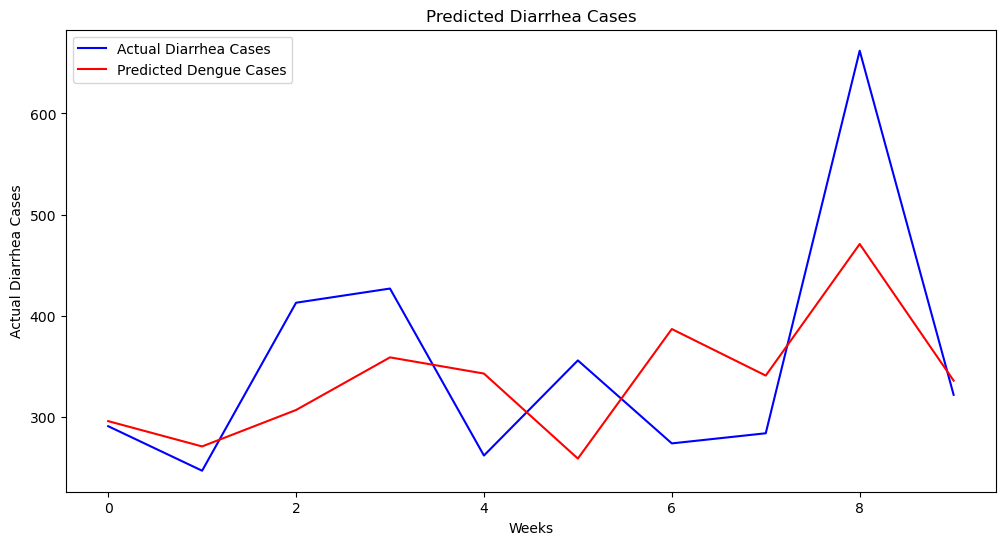

       0
291  296
247  271
413  307
427  359
262  343
356  259
274  387
284  341
662  471
322  336
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0024 - val_loss: 0.1108
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.1114
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.1201
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.1263
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.1245
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 0.1200
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.1157
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 0.1135
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.1137
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.1166
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 0.1207
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.3873e-04 - val_loss: 0.1

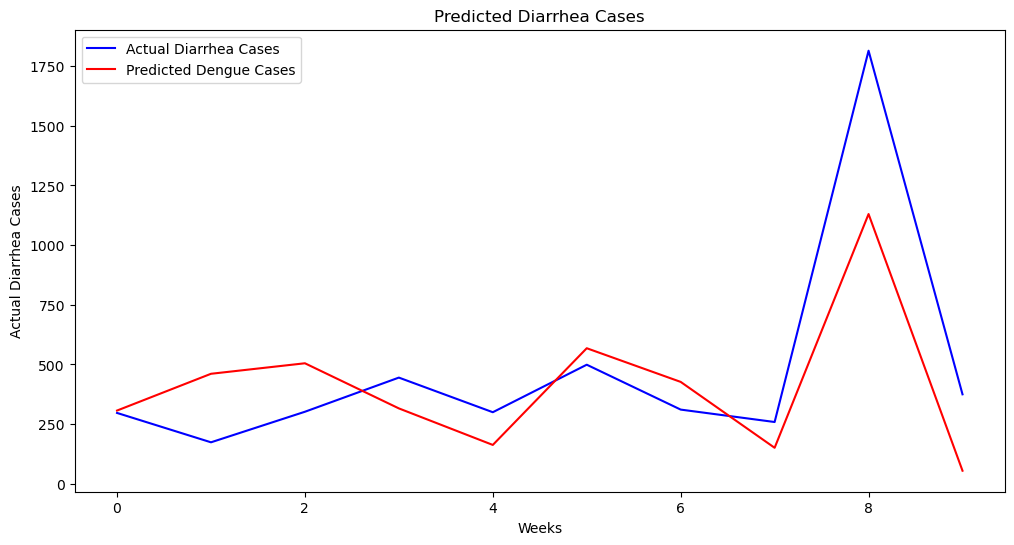

         0
297    307
174    461
302    505
445    316
300    163
499    568
311    427
259    151
1814  1130
375     55
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0979 - val_loss: 0.0507
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0636 - val_loss: 0.0260
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0389 - val_loss: 0.0114
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - val_loss: 0.0073
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293 - val_loss: 0.0101
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - val_loss: 0.0124
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0319 - val_loss: 0.0117
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273 - val_loss: 0.0093
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0234 - val_loss: 0.0071
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0240 - val_loss: 0.0064
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - val_loss: 0.0071
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0269 - val_loss: 0.0082


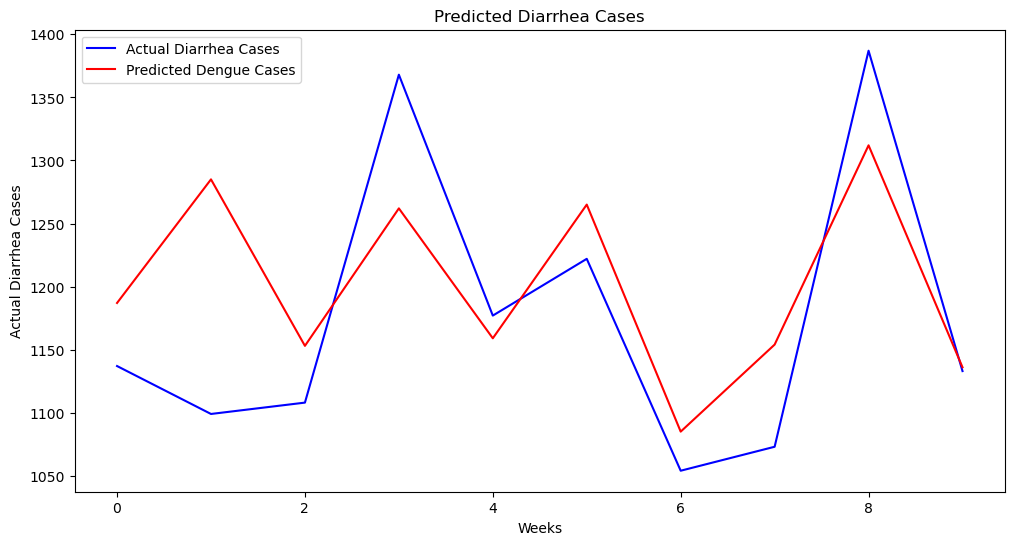

         0
1137  1187
1099  1285
1108  1153
1368  1262
1177  1159
1222  1265
1054  1085
1073  1154
1387  1312
1133  1136
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.2599 - val_loss: 0.1866
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1447 - val_loss: 0.1398
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1138 - val_loss: 0.1037
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0841 - val_loss: 0.0801
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0767 - val_loss: 0.0709
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0688 - val_loss: 0.0735
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0703 - val_loss: 0.0778
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0817 - val_loss: 0.0739
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0858 - val_loss: 0.0647
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0779 - val_loss: 0.0566
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0575 - val_loss: 0.0512
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0506 - val_loss: 0.0483


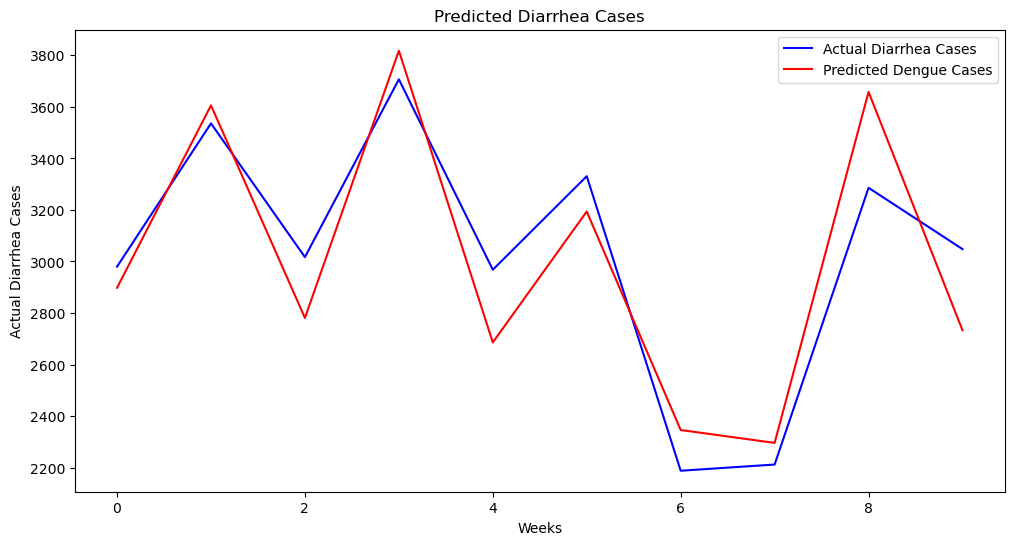

         0
2980  2898
3536  3606
3017  2781
3707  3818
2968  2686
3331  3194
2188  2346
2212  2296
3286  3658
3048  2733
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0015 - val_loss: 0.1359
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.1358
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.1264
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1918e-04 - val_loss: 0.1193
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.1179
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.1204
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2918e-04 - val_loss: 0.1248
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0289e-04 - val_loss: 0.1283
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.1280
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4870e-04 - val_loss: 0.1253
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5792e-04 - val_loss: 0.1228
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2703

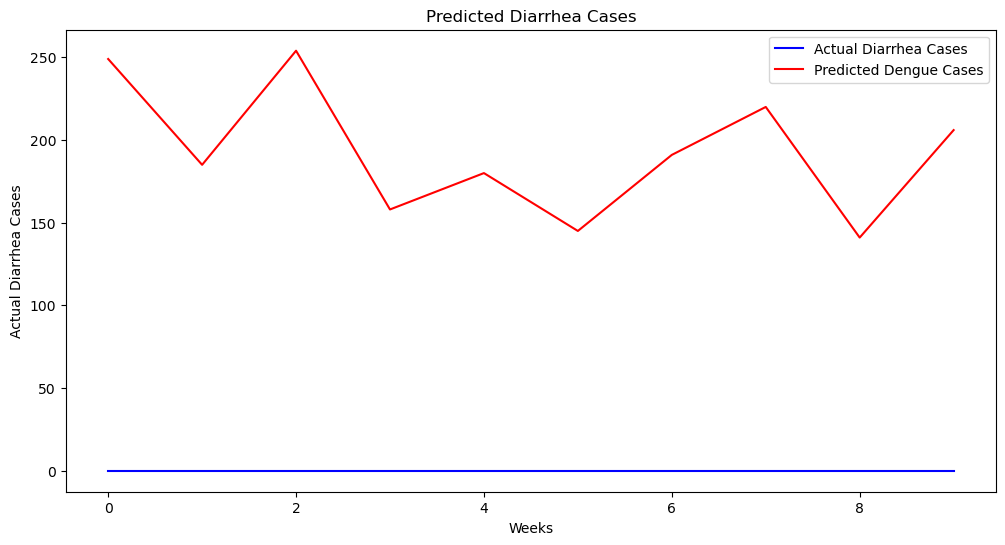

     0
0  249
0  185
0  254
0  158
0  180
0  145
0  191
0  220
0  141
0  206
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0849 - val_loss: 0.0143
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0486 - val_loss: 0.0085
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0482 - val_loss: 0.0168
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0475 - val_loss: 0.0348
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0318 - val_loss: 0.0455
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0478 - val_loss: 0.0483
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0464 - val_loss: 0.0435
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0369 - val_loss: 0.0326
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0372 - val_loss: 0.0226
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0273 - val_loss: 0.0157
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0312 - val_loss: 0.0119
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0225 - val_loss: 0.0095


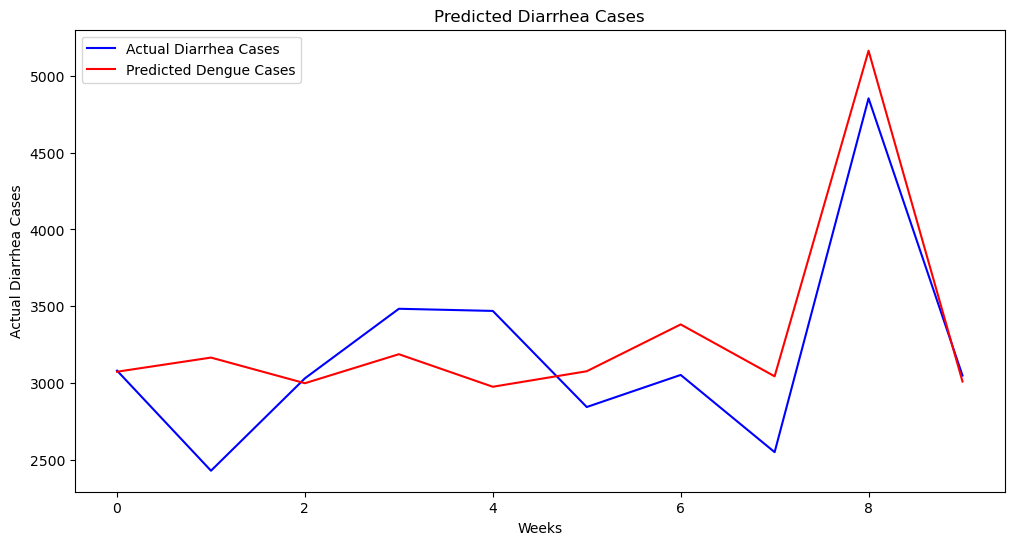

         0
3080  3073
2428  3165
3030  2998
3483  3187
3469  2975
2843  3076
3052  3381
2549  3043
4854  5164
3048  3009
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0011 - val_loss: 4.2691e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 1.0916e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6943e-04 - val_loss: 4.2345e-05
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5611e-04 - val_loss: 7.8753e-05
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5287e-04 - val_loss: 1.0404e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5705e-04 - val_loss: 7.7263e-05
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9281e-04 - val_loss: 1.6838e-04
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1381e-04 - val_loss: 1.6661e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8174e-04 - val_loss: 8.1457e-05
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6408e-04 - val_loss: 3.9966e-05
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5016e-04 - val_loss: 1.1472e-04
Epoch

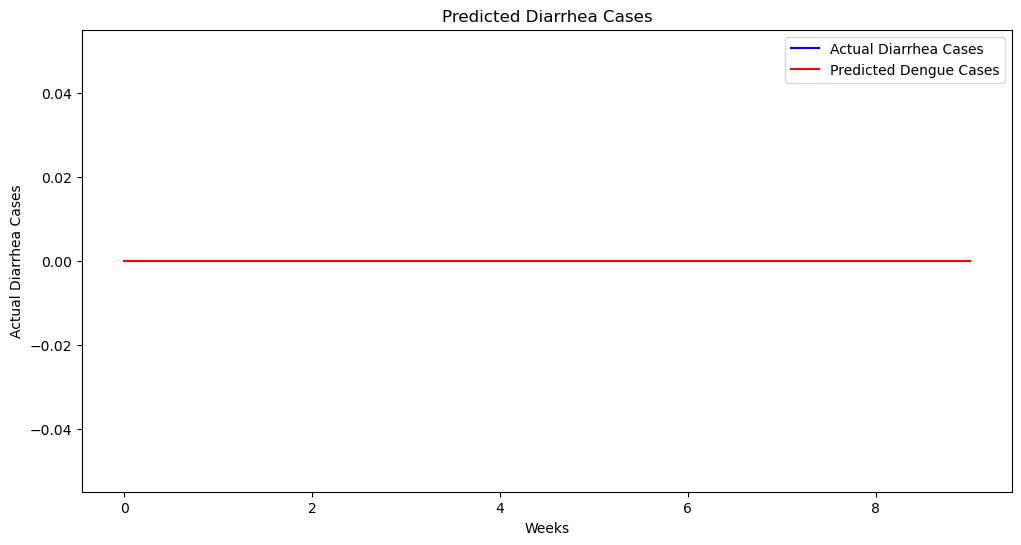

   0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.1102 - val_loss: 0.0835
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0917 - val_loss: 0.0433
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0354 - val_loss: 0.0217
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0253 - val_loss: 0.0192
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - val_loss: 0.0282
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0354 - val_loss: 0.0337
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0319 - val_loss: 0.0313
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0304 - val_loss: 0.0246
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0240 - val_loss: 0.0202
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0207 - val_loss: 0.0187
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - val_loss: 0.0195
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - val_loss: 0.0212


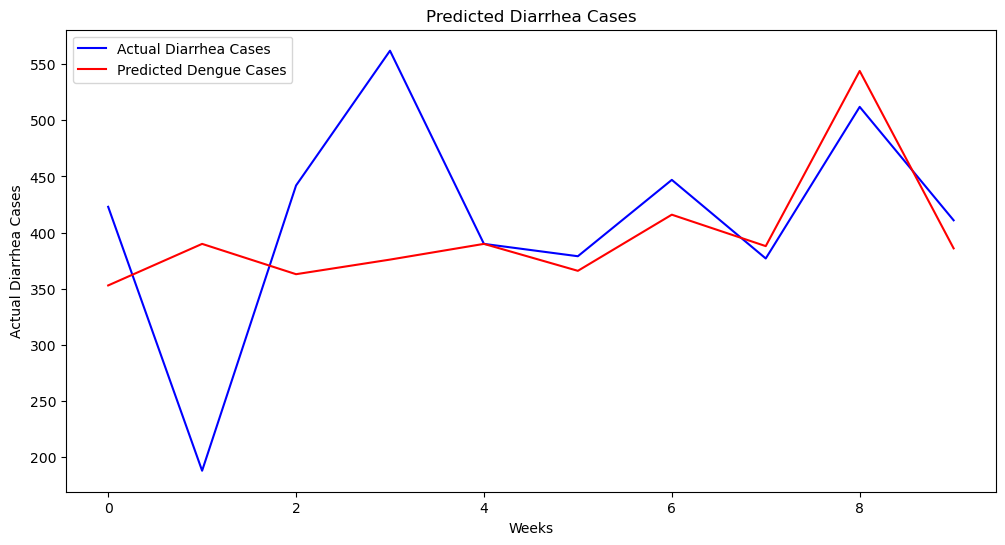

       0
423  353
188  390
442  363
562  376
390  390
379  366
447  416
377  388
512  544
411  386
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0026 - val_loss: 0.1236
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2625e-04 - val_loss: 0.1293
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8256e-04 - val_loss: 0.1267
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1730e-04 - val_loss: 0.1222
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6987e-04 - val_loss: 0.1199
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5012e-04 - val_loss: 0.1201
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7540e-04 - val_loss: 0.1223
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2947e-04 - val_loss: 0.1255
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3812e-04 - val_loss: 0.1278
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0402e-04 - val_loss: 0.1280
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2447e-04 - val_loss: 0.1261
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms

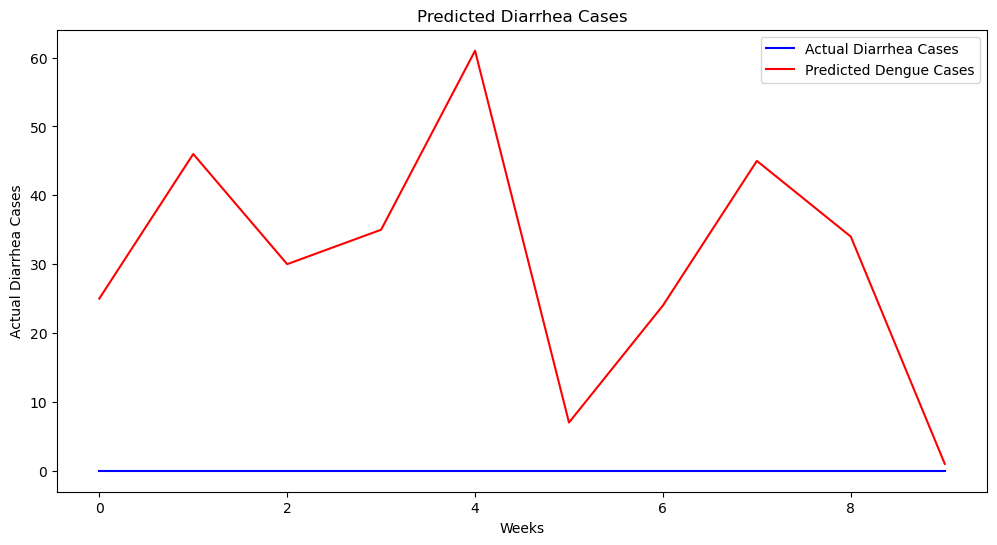

    0
0  25
0  46
0  30
0  35
0  61
0   7
0  24
0  45
0  34
0   1


In [12]:
# features = ['Week','Cases','temp_max','temp_mean','temp_min','pr_max','rh_max','rh_mean','rh_min']
# features = ['Population','Cases','temp_max','temp_mean','temp_min','pr_max','rh_max','rh_mean','rh_min']
features = ['Cases','temp_max','temp_mean','temp_min','pr_max','rh_max','rh_mean','rh_min']
for area in municipalities:
    
    predictive_area = area

# predictive_area = 'Aileu'
# predictive_week = 52.0


    municipalitiy_wise_climatology_df = returnMunicipalitiesWiseWeeklyClimatology(predictive_area)

    data = municipalitiy_wise_climatology_df[features].copy(deep=True)
    # data.head()

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[features])
    data_values = data.values
    time_steps = 4  
    X, y = create_dataset(data_scaled, time_steps)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # Reshape X to be [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])


    model.fit(X_train,y_train , epochs=100, batch_size=16, validation_split=0.2)

    predictions = model.predict(X_test)
    predictions_inverse = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0],len(features)-1 ))), axis=1))[:, 0]
    predictions_inverse= np.abs(predictions_inverse).astype(int)
    
    # Inverse transform the actual values
    y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1 ))), axis=1))[:, 0]
    y_test_inverse = np.abs(y_test_inverse).astype(int)



    print('Municipality: ', predictive_area)
    mae = mean_absolute_error(y_test, predictions)
    print(f'Mean Absolute Error: {mae}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inverse, label='Actual Diarrhea Cases', color='blue')
    plt.plot(predictions_inverse, label='Predicted Dengue Cases', color='red')
    plt.title('Predicted Diarrhea Cases')
    plt.xlabel('Weeks')
    plt.ylabel('Actual Diarrhea Cases')
    plt.legend()
    plt.show()




    print(pd.DataFrame(predictions_inverse,y_test_inverse))

    # # Save the model
    # model.save(f'../diarrehaModels/{predictive_area}.h5')  # Save in HDF5 format
    # # Save the scaler
    # joblib.dump(scaler, f'../diarrehaModels/{predictive_area}_minmax_scaler.pkl')


In [13]:
# loaded_model = keras.models.load_model(f'../dengueModels/{predictive_area}.h5')

# predict_this =[]

# # predict_this = np.array(
# #     [
# #     [13,24.862529,0.001854,94.167866],
# #     [0,24.485663,0.002161,93.885841],
# #     [21,24.475522,0.002262,94.454283],
# #     [23,24.563932,0.003393,98.315181]
# #     ]
# # )

# # predict_this = np.array(
# # [[3,25.179148,0.002434,93.914394],
# # [0,24.42601,0.002158,94.727504],
# # [13,24.862529,0.001854,94.167866],
# # [0,24.485663,0.002161,93.885841]]
# # )

# # predict_this = np.array(
# #     [
        
# #         [0,25.350255,2.330229,96.362104],
# #         [0,24.987881,2.59917,92.871751],
# #         [3,25.179148,2.433635,93.914394],
# #         [0,24.42601,2.157721,94.727504]
# #     ]
# # )


# # predict_this = np.array(
# #     [
        
# #         [25.350255,2.330229,96.362104],
# #         [24.987881,2.59917,92.871751],
# #         [25.179148,2.433635,93.914394],
# #         [24.42601,2.157721,94.727504]
# #     ]
# # )



# predict_this = np.array(
#     [
        
# [23,24.563932,3.392669,98.315181],
# [11,24.601462,2.104094,91.745313],
# [11,24.454519,2.512841,93.87814],
# [11,24.74638,2.396815,94.735382]
#     ]
# )


# # predict_this = np.array(
# #     [
# #         [0,25.350255,2.330229,96.362104],
# #         [0,24.987881,2.59917,92.871751],
# #         [3,25.179148,2.433635,93.914394],
# #         [0,24.42601,2.157721,94.727504]
# #     ]
# # )




# # predict_this = np.array(
# #     [
# # [3,25.179148,2.433635,93.914394],
# # [0,24.42601,2.157721,94.727504],
# # [13,24.862529,1.853649,94.167866],
# # [0,24.485663,2.160863,93.885841]
# #     ]
# # )


# # predict_this = np.array(
# #     [
# # [13,24.862529,1.853649,94.167866],
# # [0,24.485663,2.160863,93.885841],
# # [21,24.475522,2.262031,94.454283],
# # [23,24.563932,3.392669,98.315181]
# #     ]
# # )


# # predict_this = np.array(
# #     [
# # [0,26.093238,1.750254,87.614898],
# # [0,25.96219,1.031194,83.511341],
# # [0,26.551549,1.904125,85.178064],
# # [0,26.106114,1.879766,89.445229],
# #     ]
# # )



# # print(predict_this.shape)
# predict_this_scaled = scaler.transform(predict_this)
# predict_this_reshaped = predict_this_scaled.reshape(1,4,4)
# scaled_prediction  = loaded_model.predict(predict_this_reshaped)
# # print(scaled_prediction)
# predicted_real = scaler.inverse_transform(np.concatenate((scaled_prediction.reshape(-1, 1), np.zeros((scaled_prediction.shape[0], 3))), axis=1))[:, 0]
# print(predicted_real)

# # print(predict_this.shape)
# # predict_this_reshaped = predict_this.reshape(1,4,4)